In [1]:
import pyemu
import flopy as fp
import os, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/mnfienen/opt/miniconda3/envs/modflow_training/lib/python3.11/site-packages/pyemu/pst/pst_handler.py:15: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


## define a location for the background files to start with, and a setup directory to copy to and work in

In [2]:
org_d = Path('../pest_background_files/')
t_d = Path('../pest_ies_setup')

In [3]:
if t_d.exists():
    shutil.rmtree(t_d)
shutil.copytree(org_d,t_d)


PosixPath('../pest_ies_setup')

### get spatial reference for the model - pilot points are based on geographic coordinates (not on layer/row/column)

In [4]:
sim = fp.mf6.MFSimulation.load(sim_ws = str(t_d))
gwf = sim.get_model()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package chd...
    loading package rch...
    loading package riv...
    loading package wel...
    loading package obs...
  loading solution package at...


In [5]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        str(t_d / "at.nam"),
        delr=gwf.dis.delr.array, delc=gwf.dis.delc.array)
sr

   could not remove start_datetime


xul:0; yul:20000; rotation:0; proj4_str:None; units:meters; lenuni:2; length_multiplier:1.0

### set up variograms for K pilot points

In [6]:
pp_aq = 3
# exponential variogram for spatially varying parameters
v_aq = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=pp_aq * 3 * sr.delc[0], # range of correlation; length units of the model. In our case 'meters'
                                    anisotropy=1.0, #name says it all
                                    bearing=0.0 #angle in degrees East of North corresponding to anisotropy ellipse
                                    )

# geostatistical structure for spatially varying parameters
aq_gs = pyemu.geostats.GeoStruct(variograms=v_aq, transform='log') 

<Axes: xlabel='distance', ylabel='$\\gamma$'>

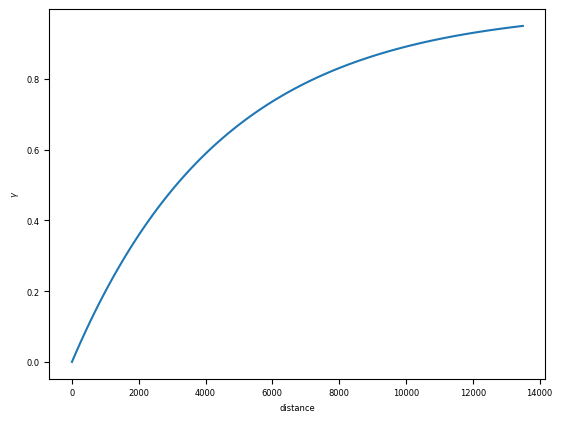

In [7]:
v_aq.plot()

In [8]:
pp_clay=6
# exponential variogram for spatially varying parameters
v_clay = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=pp_clay * 5 * sr.delc[0], # range of correlation; length units of the model. In our case 'meters'
                                    anisotropy=1.0, #name says it all
                                    bearing=0.0 #angle in degrees East of North corresponding to anisotropy ellipse
                                    )

# geostatistical structure for spatially varying parameters
clay_gs = pyemu.geostats.GeoStruct(variograms=v_clay, transform='log') 

<Axes: xlabel='distance', ylabel='$\\gamma$'>

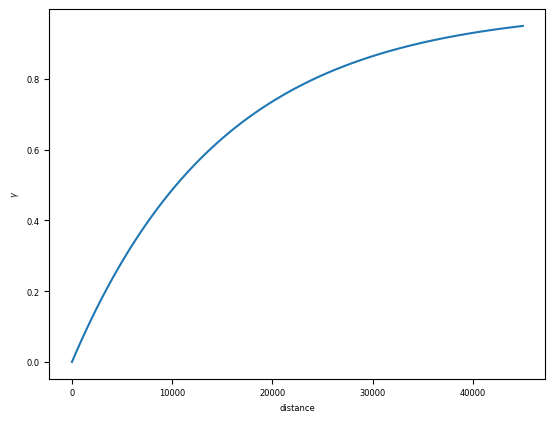

In [9]:
v_clay.plot()

In [10]:
ib = gwf.dis.idomain.array[0]


### we only need pilot points for two unique K files - k_aq and k_clay

In [11]:
k_aq = np.loadtxt(t_d/'k_aq.ref')
k_clay = np.loadtxt(t_d/'k_clay.ref')


Text(0.5, 1.0, 'clay')

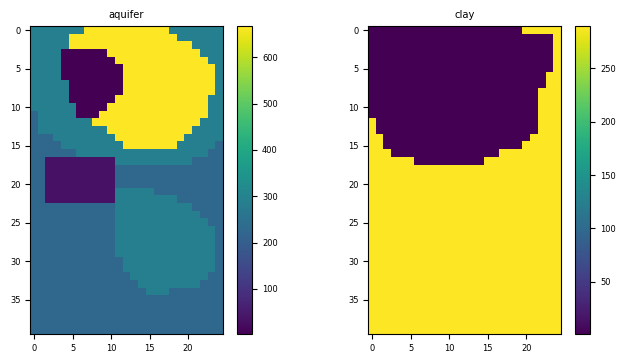

In [12]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
c = ax[0].imshow(k_aq)
plt.colorbar(c, ax=ax[0])
ax[0].set_title('aquifer')
c1 = ax[1].imshow(k_clay)
plt.colorbar(c1, ax=ax[1])
ax[1].set_title('clay')


### we can define spatial zones based on the initial K values, assuming they are grouped as homogeneous and unique values

In [13]:
uniq_aq = np.unique(k_aq)
aq_zones_dict = dict(zip(np.arange(1,len(uniq_aq)+1), uniq_aq))
aq_zones_dict

{1: 2.0876697546,
 2: 34.962617819,
 3: 225.52388062,
 4: 289.48642696,
 5: 666.73361113}

In [14]:
uniq_clay = np.unique(k_clay)
clay_zones_dict = dict(zip(np.arange(1,len(uniq_clay)+1), uniq_clay))
clay_zones_dict

{1: 0.76160437974, 2: 289.48642696}

### make integer arrays of zones for the unique values of the aquifer ... 

In [15]:
aq_zones = np.zeros_like(k_aq)
for ck, cv in aq_zones_dict.items():
    aq_zones[k_aq==cv] = ck


### ... and the clay

In [16]:
# only put pilot points in the clay where the clay is actually present
clay_zones = np.zeros_like(k_aq)
clay_zones[k_clay==clay_zones_dict[1]] = 1

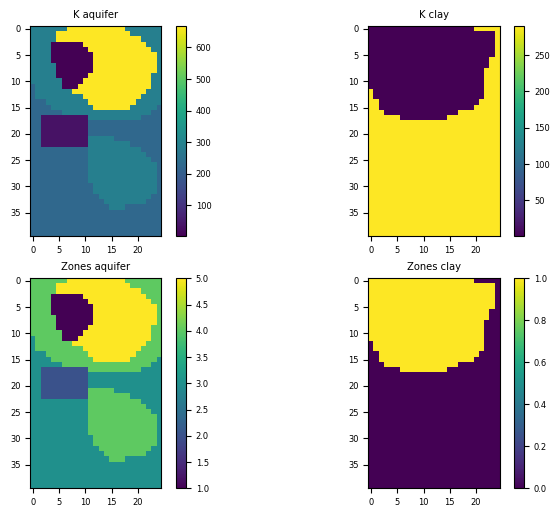

In [17]:
fig,ax = plt.subplots(2,2,figsize=(8,6))
ax=ax.ravel()
c = ax[0].imshow(k_aq)
plt.colorbar(c, ax=ax[0])
ax[0].set_title('K aquifer')
c1 = ax[1].imshow(k_clay)
plt.colorbar(c1, ax=ax[1])
ax[1].set_title('K clay')

c2 = ax[2].imshow(aq_zones)
plt.colorbar(c2, ax=ax[2])
ax[2].set_title('Zones aquifer')

c3 = ax[3].imshow(clay_zones)
plt.colorbar(c3, ax=ax[3])
ax[3].set_title('Zones clay');


## let's set up pilot points for the k files

In [18]:
aq_pp_df = pyemu.pp_utils.setup_pilotpoints_grid(sr=sr,  # model spatial reference
                                              ibound=aq_zones, # to which cells to setup ppoints
                                              # ibound=np.ones_like(aq_zones),
                                              prefix_dict={0:['hk_aq']}, #prefix to add to parameter names
                                              pp_dir=t_d, 
                                              tpl_dir=t_d, 
                                                 shapename=str(t_d / 'pp_aq.shp'),
                                                use_ibound_zones=True,
                                              every_n_cell=pp_aq) # pilot point spacing

(0.0, 12500.0)

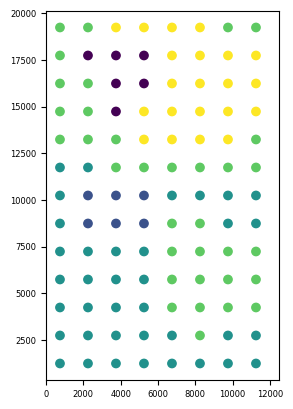

In [19]:
plt.scatter(x=aq_pp_df.x,y=aq_pp_df.y, c=aq_pp_df.zone)
plt.axis('square')
plt.xlim([0,12500])

In [20]:
clay_pp_df = pyemu.pp_utils.setup_pilotpoints_grid(sr=sr,  # model spatial reference
                                              ibound=clay_zones, # to which cells to setup ppoints
                                              prefix_dict={0:['hk_clay']}, #prefix to add to parameter names
                                              pp_dir=t_d, 
                                              tpl_dir=t_d, 
                                            shapename=str(t_d / 'pp_clay.shp'),
                                                use_ibound_zones=True,
                                              every_n_cell=pp_clay,
                                              ) # pilot point spacing

(0.0, 12500.0)

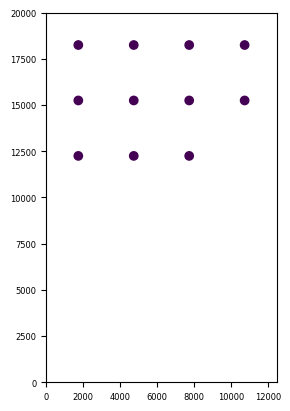

In [21]:
plt.scatter(x=clay_pp_df.x,y=clay_pp_df.y, c=clay_pp_df.zone)
plt.axis('square')
plt.ylim([0,20000])
plt.xlim([0,12500])

In [22]:
list(t_d.glob('*.tpl'))

[PosixPath('../pest_ies_setup/hk_aqpp.dat.tpl'),
 PosixPath('../pest_ies_setup/at.rch.tpl'),
 PosixPath('../pest_ies_setup/riv.ref.tpl'),
 PosixPath('../pest_ies_setup/hk_claypp.dat.tpl'),
 PosixPath('../pest_ies_setup/at.npf.tpl')]

In [23]:
list(t_d.glob('*.ins'))

[PosixPath('../pest_ies_setup/allobs.dat.ins')]

In [24]:
aq_pp_df.pargp

0      hk_aq
1      hk_aq
2      hk_aq
3      hk_aq
4      hk_aq
       ...  
99     hk_aq
100    hk_aq
101    hk_aq
102    hk_aq
103    hk_aq
Name: pargp, Length: 104, dtype: object

In [25]:
ok_aq = pyemu.geostats.OrdinaryKrige(aq_gs,aq_pp_df.loc[aq_pp_df.pargp=='hk_aq'])
ok_clay = pyemu.geostats.OrdinaryKrige(clay_gs,clay_pp_df.loc[clay_pp_df.pargp=='hk_clay'])


In [26]:
aq_fac_df = ok_aq.calc_factors_grid(sr, minpts_interp=1,maxpts_interp=10, )
clay_fac_df = ok_clay.calc_factors_grid(sr, minpts_interp=1,maxpts_interp=10, )


starting interp point loop for 1000 points
took 0.646795 seconds
starting interp point loop for 1000 points
took 0.68343 seconds


In [27]:
ok_aq.to_grid_factors_file(str(t_d / 'pp_aq.fac'))
ok_clay.to_grid_factors_file(str(t_d / 'pp_clay.fac'))


In [28]:
list(t_d.glob('*.fac'))

[PosixPath('../pest_ies_setup/pp_clay.fac'),
 PosixPath('../pest_ies_setup/pp_aq.fac')]

In [29]:
aq_fac_df

,x,y,idist,inames,ifacts,err_var
0,250.0,19750.0,"[707.1067811865476, 2061.5528128088304, 2061.5528128088304, 3535.5339059327375, 3535.53390593273...","[pp_0000, pp_0001, pp_0008, pp_0002, pp_0016, pp_0018, pp_0003]","[0.7736179117782175, 0.05089159447134091, 0.05037739169795752, 0.02155424462216176, 0.0448270508...",0.133189
1,750.0,19750.0,"[500.0, 1581.1388300841897, 3041.38126514911, 3500.0, 4527.6925690687085, 4609.772228646444]","[pp_0000, pp_0001, pp_0002, pp_0016, pp_0003, pp_0018]","[0.7843888886459814, 0.13541864223493308, 0.02318743266002807, 0.01831260443412193, 0.0279338127...",0.107867
2,1250.0,19750.0,"[707.1067811865476, 1118.033988749895, 2549.5097567963926, 3535.5339059327375, 4031.128874149275...","[pp_0000, pp_0001, pp_0002, pp_0016, pp_0003, pp_0018]","[0.6011194011821877, 0.33078768259614405, 0.03065277716852215, 0.005782102319957127, 0.025250820...",0.148857
3,1750.0,19750.0,"[707.1067811865476, 1118.033988749895, 2061.5528128088304, 3535.5339059327375, 3640.054944640259...","[pp_0001, pp_0000, pp_0002, pp_0003, pp_0016, pp_0018]","[0.5600859642844322, 0.35025856030235564, 0.05402016804187807, 0.02695502845743709, 0.0039420316...",0.154230
4,2250.0,19750.0,"[500.0, 1581.1388300841897, 1581.1388300841897, 3041.38126514911, 3500.0, 3807.886552931954]","[pp_0001, pp_0000, pp_0002, pp_0003, pp_0017, pp_0018]","[0.6770413164906338, 0.15025792389373333, 0.13286255283924858, 0.032148952809166645, 0.003163240...",0.127366
...,...,...,...,...,...,...
995,10250.0,250.0,"[1118.033988749895, 1414.213562373095, 2236.06797749979, 3640.0549446402592, 4031.128874149275, ...","[pp_0102, pp_0103, pp_0101, pp_0100, pp_0086, pp_0087, pp_0092]","[0.43970862281869355, 0.36619504938290687, 0.10859184829498857, 0.05739905229012797, 0.006931027...",0.200424
996,10750.0,250.0,"[1118.033988749895, 1414.213562373095, 2692.582403567252, 4031.128874149275, 4123.105625617661, ...","[pp_0103, pp_0102, pp_0101, pp_0087, pp_0100, pp_0086, pp_0085]","[0.5243873674289161, 0.31486280305451214, 0.06899838438360371, 0.021714392461016616, 0.053493192...",0.194072
997,11250.0,250.0,"[1000.0, 1802.7756377319947, 3162.2776601683795, 4000.0, 4272.001872658766, 4609.772228646444, 5...","[pp_0103, pp_0102, pp_0101, pp_0087, pp_0086, pp_0100, pp_0085]","[0.6475592262793268, 0.1925534368544475, 0.05008431603937684, 0.03364689968778511, 0.00043367930...",0.181107
998,11750.0,250.0,"[1118.033988749895, 2236.06797749979, 2549.5097567963926, 3640.0549446402592, 4031.128874149275,...","[pp_0103, pp_0102, pp_0095, pp_0101, pp_0087, pp_0100, pp_0085]","[0.6822250583264885, 0.10994162681244529, 0.023471091602661167, 0.04066141482321463, 0.053619358...",0.190696


### now make a PST file

In [30]:
cwd = Path(os.getcwd())
os.chdir(t_d)
pst = pyemu.Pst.from_io_files(*pyemu.helpers.parse_dir_for_io_files('.'))
os.chdir(cwd)

### set initial parameter values

In [31]:
pars = pst.parameter_data

### first set constant parameter values

In [32]:
pars.loc[pars.parnme.str.contains('aniso')]

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,i,j,zone
kaniso,kaniso,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,NaN,NaN,NaN
kaniso_clay,kaniso_clay,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,NaN,NaN,NaN


In [33]:
pars.loc['rv1', 'parval1'] = 1e+05
pars.loc['rv1', 'parlbnd'] = 1e+03
pars.loc['rv1', 'parubnd'] = 1e+06
pars.loc['rv1', 'pargp'] = 'riv_cond'

pars.loc['rch', 'parval1'] = 0.003641
pars.loc['rch', 'parlbnd'] = 0.003641*.9
pars.loc['rch', 'parubnd'] = 0.003641*1.1
pars.loc['rch', 'pargp'] = 'rch'

pars.loc['kaniso', 'parval1'] = 0.2
pars.loc['kaniso', 'parlbnd'] = 0.001
pars.loc['kaniso', 'parubnd'] = 0.85
pars.loc['kaniso', 'pargp'] = 'anisotropy'

pars.loc['kaniso_clay', 'parval1'] = 0.5
pars.loc['kaniso_clay', 'parlbnd'] = 0.001
pars.loc['kaniso_clay', 'parubnd'] = 0.85
pars.loc['kaniso_clay', 'pargp'] = 'anisotropy_clay'

### next group parameters by their arrays and zones

In [34]:
pars.loc[~pars.zone.isnull(), 'pargp'] = [f"{i.split('_i:')[0]}_{int(float(z))}" for 
                                          i,z in zip(pars.loc[~pars.zone.isnull()].parnme,
                                                     pars.loc[~pars.zone.isnull()].zone)]

In [35]:
pars.zone = [float(i) for i in pars.zone]

### Without enforcing too much structure, we can adjust a few starting values and bounds to inform ies of at least some of the general patterns of K values

In [36]:
pars.loc[pars.pargp.str.contains('hk_aq'), 'parval1'] = 200
pars.loc[pars.pargp.str.contains('hk_aq'), 'parlbnd'] = .01
pars.loc[pars.pargp.str.contains('hk_aq'), 'parubnd'] = 1e3
pars.loc[pars.pargp.str.contains('hk_clay'), 'parval1'] = 1
pars.loc[pars.pargp.str.contains('hk_clay'), 'parlbnd'] = .0001
pars.loc[pars.pargp.str.contains('hk_clay'), 'parubnd'] = 1e2
pars.loc[pars.pargp=='hk_aq_5', 'parval1'] = 200
pars.loc[pars.pargp=='hk_aq_4', 'parval1'] = 200
pars.loc[pars.pargp=='hk_aq_3', 'parval1'] = 200
pars.loc[pars.pargp=='hk_aq_4', 'parubnd'] = 750
pars.loc[pars.pargp=='hk_aq_3', 'parubnd'] = 500
pars.loc[pars.pargp=='hk_clay_1', 'parval1'] = 1
pars.loc[pars.pargp=='hk_clay_2', 'parval1'] = 150
pars.loc[pars.pargp=='hk_clay_2', 'parlbnd'] = 1
pars.loc[pars.pargp=='hk_clay_2', 'parubnd'] = 1000

## read in the observation values and set them

In [37]:
obsvals = pd.read_csv(t_d / 'obsvalues.dat', delim_whitespace=True, index_col=0)
obsvals.sample(5)

,obsval,weight,obgnme
obsnme,,,
w16,2.73,1.0,headgroup
w12,4.18,1.0,headgroup
w02,11.35,1.0,headgroup
w07,9.13,1.0,headgroup
w15,4.57,1.0,headgroup


In [38]:
pst.observation_data.sample(5)

,obsnme,obsval,weight,obgnme
u12,u12,4.341405,1.0,obgnme
w15,w15,4.527698,1.0,obgnme
u11,u11,3.255424,1.0,obgnme
u15,u15,4.535909,1.0,obgnme
u09,u09,8.839738,1.0,obgnme


In [39]:
pst.observation_data.loc[obsvals.index,'obgnme'] = obsvals.obgnme
pst.observation_data.loc[obsvals.index,'obsval'] = obsvals.obsval
pst.observation_data.loc[obsvals.index,'weight'] = obsvals.weight

pst.observation_data

,obsnme,obsval,weight,obgnme
chdflow,chdflow,33390.41096,0.000299,lakegroup
ds,ds,-894494.00000,0.000013,rivgroup
pf,pf,-96402.00000,0.000104,rivgroup
u01,u01,12.05000,1.000000,headgroup
u02,u02,11.63000,1.000000,headgroup
u03,u03,12.15000,1.000000,headgroup
u04,u04,11.44000,1.000000,headgroup
u05,u05,10.86000,1.000000,headgroup
u06,u06,10.80000,1.000000,headgroup
u07,u07,9.16000,1.000000,headgroup


### now we need to write out the `forward_run` script that includes pilot point interpolation, running MF6, and postprocesses the observations to prepare them for reading

In [40]:
with open(t_d / 'forward_run.py','w') as f:
    #add imports
    f.write("import os\nimport shutil\nimport numpy as np\nimport pyemu\nimport flopy\n")
    f.write("import pandas as pd\n")
    # preprocess pilot points to grid
    f.write("_ = pyemu.geostats.fac2real('hk_aqpp.dat', factors_file='pp_aq.fac',out_file='k_aq.ref')\n")
    f.write("_ = pyemu.geostats.fac2real('hk_claypp.dat', factors_file='pp_clay.fac',out_file='k_clay.ref')\n")
    # run MF6
    f.write("pyemu.os_utils.run('mf6')\n")
    # process the observations
    f.write("outfiles = ['./riv.csv','./at.wt.csv','./chd.csv','./at.csv']\n")
    f.write("obs = pd.concat([pd.read_csv(i).T.iloc[1:] for i in outfiles])\n")
    f.write("obs.loc['DS'] = obs.loc['DS'] + obs.loc['PF']\n") # note that we have to add the two river obs
    f.write("obs.columns=['obsname']\n")
    f.write('obs.to_csv("allobs.dat", sep = " ")')
    

### now set a few ies-specific values and write out the file

In [41]:
pst.model_command = ['python forward_run.py']
pst.control_data.noptmax = 0

pst.pestpp_options['ies_num_reals'] = 150
pst.pestpp_options['par_sigma_range'] = 6
pst.pestpp_options['ies_no_noise']='true'
pst.write(str(t_d / 'mv.ies.pst'))

noptmax:0, npar_adj:119, nnz_obs:37


### copy the run folder over to be a master for parallel runs

In [42]:
rundir = Path('../tmprun')
if rundir.exists():
    shutil.rmtree(rundir)
shutil.copytree(t_d, rundir)

PosixPath('../tmprun')

## now we need to balance the objective function - we can start based on the initial run

### run the model once through PEST

In [43]:
pyemu.os_utils.run('pestpp-ies mv.ies.pst', str(rundir))



             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team


version: 5.2.7
binary compiled on Sep  5 2023 at 07:38:31

started at 09/14/23 16:25:54
...processing command line: ' pestpp-ies mv.ies.pst'
...using serial run manager

using control file: "mv.ies.pst"
in directory: "/Users/mnfienen/Documents/GIT/modflow-memphis-2023/exercises/PEST/tmprun"
on host: "IGSACB116LHMNFI"

processing control file mv.ies.pst

Note: 'NOPTMAX' == 0, switching to forgiveness mode when checking inputs

Note: 3 unused lines in pest control file, see rec file...
noptmax = 0, resetting max_run_fail = 1
checking model IO files...done
              starting serial run manager ...


  ---  initializing  ---  

  ---  'noptmax'=0, running control file parameter values and quitting  ---  
...saving control file parameter ensemble to  mv.ies.base.par.csv
...initializing prior parameter covariance matrix
...parcov loaded  from parameter bounds, using par_sigma

/Users/mnfienen/opt/miniconda3/envs/modflow_training/lib/python3.11/site-packages/pyemu/pst/pst_handler.py:15: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:29:14 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthoriz

### now read in the residuals and see how things look

In [44]:
pst_new = pyemu.Pst(str(rundir / 'mv.ies.pst'))

<Axes: >

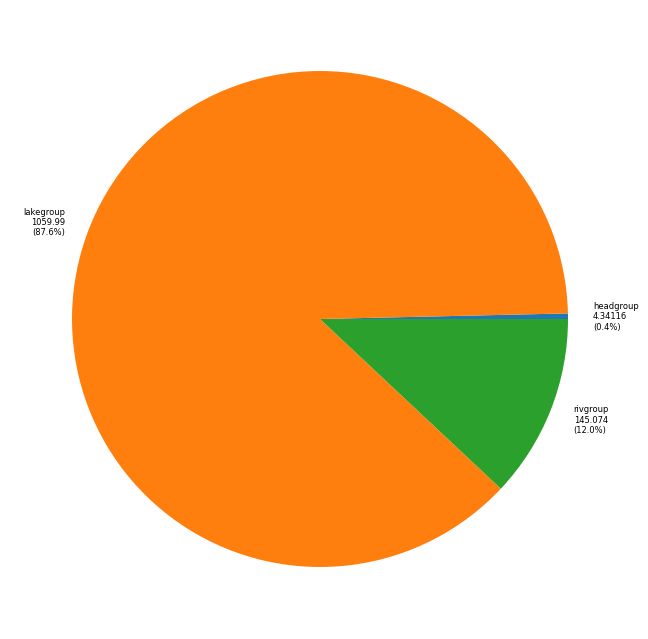

In [45]:
pst_new.plot(kind='phi_pie')

### what are the components of the objective function?

In [46]:
pst_new.phi_components

{'headgroup': 4.341162000475988,
 'lakegroup': 1059.9920169070535,
 'rivgroup': 145.07415497942932}

In [47]:
phi = pst_new.phi
phi

1209.407333886959

In [48]:
new_components = {'headgroup': phi*.25,
            'lakegroup': phi*.25,
            'rivgroup' : phi*.5}

In [49]:
pst_new.adjust_weights(obsgrp_dict=new_components)

In [50]:
pst_new.phi_components

{'headgroup': 302.3518334717398,
 'lakegroup': 302.3518334717397,
 'rivgroup': 604.7036669434796}

<Axes: >

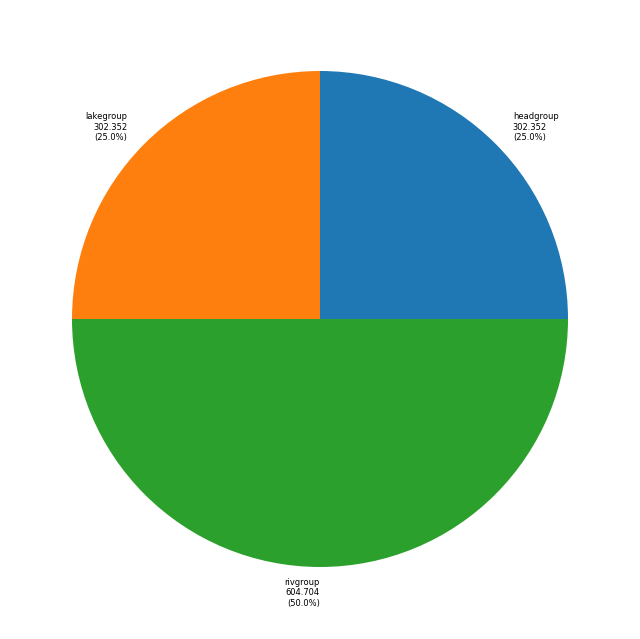

In [51]:
pst_new.plot(kind='phi_pie')

In [52]:
pst_new.observation_data

,obsnme,obsval,weight,obgnme,extra
obsnme,,,,,
chdflow,chdflow,33390.41096,0.000160,lakegroup,NaN
ds,ds,-894494.00000,0.000026,rivgroup,NaN
pf,pf,-96402.00000,0.000212,rivgroup,NaN
u01,u01,12.05000,8.345518,headgroup,NaN
u02,u02,11.63000,8.345518,headgroup,NaN
u03,u03,12.15000,8.345518,headgroup,NaN
u04,u04,11.44000,8.345518,headgroup,NaN
u05,u05,10.86000,8.345518,headgroup,NaN
u06,u06,10.80000,8.345518,headgroup,NaN


In [53]:
pst_new.control_data.noptmax=3

In [54]:
pst_new.write(str(rundir / 'mv.ies.pst'))
pst_new.write(str(t_d / 'mv.ies.pst'))


noptmax:3, npar_adj:119, nnz_obs:37
noptmax:3, npar_adj:119, nnz_obs:37


### now run the parameter estimation in parallel

In [55]:
run_flag = True
if run_flag:
    pyemu.os_utils.start_workers(str(t_d),num_workers=15, master_dir=str(rundir), 
                             exe_rel_path='pestpp-ies',
                            pst_rel_path='mv.ies.pst')



             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team


version: 5.2.7
binary compiled on Sep  5 2023 at 07:38:31

started at 09/14/23 16:25:56
...processing command line: ' pestpp-ies mv.ies.pst /h :4004'
...using panther run manager in master mode using port 4004

using control file: "mv.ies.pst"
in directory: "/Users/mnfienen/Documents/GIT/modflow-memphis-2023/exercises/PEST/tmprun"
on host: "IGSACB116LHMNFI"

processing control file mv.ies.pst
Note: 3 unused lines in pest control file, see rec file...


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     . ..:::::::....:::.  `: .'
    :..    ____::::